In [1]:
%%capture
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip3 install seaborn
import string

In [2]:
import seaborn as sns

# Load, Inspect, and Clean DataFrame

In [6]:
read_data  = pd.read_pickle('../stories') # read in data from pickle
story_df = pd.DataFrame(read_data) # create df from pickle data
raw_df = pd.DataFrame(pd.read_csv("../nytwit_v1-1.tsv", sep='\t')) # core df we will concat sentence data to


In [7]:
raw_df_filtered = raw_df.drop(raw_df.loc[raw_df['URL'].values == 'not found'].index, axis = 0) # drop rows where URL is not found


In [8]:
story_df = story_df.rename(columns={
    0:"Story_Examples"
})
story_df.head()

,Story_Examples
0,“How much does it cost ” I asked Hirota We wer...
1,“How much does it cost ” I asked Hirota We wer...
2,“How much does it cost ” I asked Hirota We wer...
3,Last month an Access Hollywood correspondent ...
4,CANYON DE CHELLY Ariz — A sliver moon dangle...


# Clean up the Story DF

In [9]:
story_df.reset_index(drop=True, inplace=True)

def remove_punctuation(text):
    no_punct = "".join([w for w in text if w not in string.punctuation])
    no_punct.replace('"', "")
    return no_punct

story_df['Story_Examples'] = story_df['Story_Examples'].apply(lambda x: remove_punctuation(x)) # remove punctuation from sentences

In [10]:
story_df

,Story_Examples
0,“How much does it cost ” I asked Hirota We wer...
1,“How much does it cost ” I asked Hirota We wer...
2,“How much does it cost ” I asked Hirota We wer...
3,Last month an Access Hollywood correspondent ...
4,CANYON DE CHELLY Ariz — A sliver moon dangle...
...,...
2577,LOS ANGELES — Even before she turned 17 in Dec...
2578,LOS ANGELES — Even before she turned 17 in Dec...
2579,ImageCredit Till Lauer A newsletter for pare...
2580,Great horror writing is more than cheap scares...


# Clean up the Core DF

In [11]:
raw_df_filtered.reset_index(drop=True, inplace=True)
raw_df_filtered.head()

,Time,Word,Category,URL
0,Tue Nov 07 19:12:11 2017,ujigami,filtered,https://www.nytimes.com/2017/11/07/travel/shri...
1,Tue Nov 07 19:12:15 2017,ganbarro,filtered,https://www.nytimes.com/2017/11/07/travel/shri...
2,Tue Nov 07 19:12:25 2017,yamahoko,filtered,https://www.nytimes.com/2017/11/07/travel/shri...
3,Wed Nov 08 10:01:04 2017,rememed,affix,https://www.nytimes.com/2017/11/08/opinion/ang...
4,Wed Nov 08 11:01:14 2017,andpinyon,filtered,https://www.nytimes.com/2017/11/08/sports/nava...


# Concat dataframes, perform final inspections of the data

In [12]:
df = pd.concat([raw_df_filtered, story_df], axis =1)

In [13]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['Time', 'Word', 'Category', 'URL', 'Story_Examples'], dtype='object')

### Check for empty strings

In [15]:
df = df.drop(df.loc[df['Story_Examples'] == ''].index, axis = 0) # drop words with no stories , i.e. the URL did not work or the stories are no longer public
df.reset_index(drop=True, inplace=True)


In [16]:
df.Story_Examples

0       “How much does it cost ” I asked Hirota We wer...
1       “How much does it cost ” I asked Hirota We wer...
2       “How much does it cost ” I asked Hirota We wer...
3       Last month  an Access Hollywood correspondent ...
4       CANYON DE CHELLY  Ariz  — A sliver moon dangle...
                              ...                        
2577    LOS ANGELES — Even before she turned 17 in Dec...
2578    LOS ANGELES — Even before she turned 17 in Dec...
2579    ImageCredit   Till Lauer A newsletter for pare...
2580    Great horror writing is more than cheap scares...
2581    There they are  the racks of meat on skewers a...
Name: Story_Examples, Length: 2582, dtype: object

# Number of NA's

In [17]:
sum(pd.isna(df.Story_Examples))

0

# Calculate length of stories in Story_Examples

In [19]:
story_lengths_all = [len(story.split(" ")) for story in df.Story_Examples]
max_min_difference = abs(np.min(story_lengths_all) - np.max(story_lengths_all))

#5-number summary
min_ = np.min(story_lengths_all)
q1 = np.quantile(a = story_lengths_all, q = .25)
q2 = np.quantile(a = story_lengths_all, q = .5)
q3 = np.quantile(a = story_lengths_all, q = .75)
max_ = np.max(story_lengths_all)
#basic stats
iqr = q3 - q1

max_non_outlier = q3 + 1.5*iqr
min_non_outlier = q1 - 1.5*iqr

outlier_story_lengths = [length for length in story_lengths_all if (length > max_non_outlier) | (length < min_non_outlier)]
remove_extremities = [val for val in story_lengths_all if val < 40000]


print("IQR is {}".format(iqr))
print("MAX is {}".format(max_))
print("MIN is {}".format(min_))
print("Q1 is {}".format(q1))
print("Q3 is {}".format(q3))
print("Min Outlier Threshold is {}".format(min_non_outlier))
print("Max Outlier Threshold is {}".format(max_non_outlier))
print(str(round((len(outlier_story_lengths)/len(story_lengths_all))*100, 2)) + "% of the story lengths are outliers.") # % of dataset that is an outlier...


IQR is 725.5
MAX is 13206
MIN is 91
Q1 is 945.5
Q3 is 1671.0
Min Outlier Threshold is -142.75
Max Outlier Threshold is 2759.25
8.83% of the story lengths are outliers.


[[]]

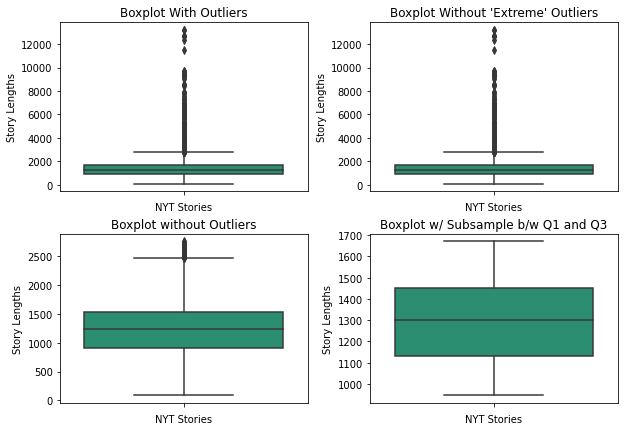

In [20]:
# set up figure
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(10)
plt.subplots_adjust(wspace = .25, hspace=.25)

#subplot 0,0
ax1.title.set_text("Boxplot With Outliers")
ax1.set_xlabel("NYT Stories")
ax1.set_ylabel("Story Lengths")
plot1 = sns.boxplot(data = story_lengths_all, color=sns.set_palette("Dark2"), ax=ax1)
plot1.set(xticklabels=[])


#subplot 0,1
ax2.title.set_text("Boxplot Without 'Extreme' Outliers")
ax2.set_xlabel("NYT Stories")
ax2.set_ylabel("Story Lengths")
plot2 =sns.boxplot(data = remove_extremities, ax=ax2) 
plot2.set(xticklabels=[])

#subplot 1, 0
ax3.title.set_text("Boxplot without Outliers")
ax3.set_xlabel("NYT Stories")
ax3.set_ylabel("Story Lengths")
plot3 = sns.boxplot(data = [length for length in story_lengths_all if ((length>= min_non_outlier) & (length <= max_non_outlier))], ax = ax3)
plot3.set(xticklabels=[])

#subplot 1, 1
ax4.title.set_text("Boxplot w/ Subsample b/w Q1 and Q3")
ax4.set_xlabel("NYT Stories")
ax4.set_ylabel("Story Lengths")
plot4 = sns.boxplot(data = [length for length in story_lengths_all if ((length>=q1) & (length <= q3))], ax = ax4)
plot4.set(xticklabels=[])

# Empirical CDF to show us what % of the data lies below a certain sentence length 

Text(0, 0.5, '% of stories')

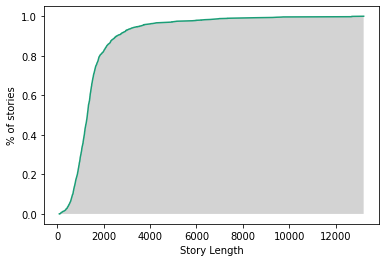

In [21]:
plt.plot(np.sort(story_lengths_all), np.linspace(0, 1, len(story_lengths_all)))
plt.fill_between(np.sort(story_lengths_all), np.linspace(0, 1, len(story_lengths_all)), facecolor='lightgray')
plt.xlabel("Story Length")
plt.ylabel("% of stories")

### roughly 90% of our story lengths fall below 2000 words. 

In [22]:
%%capture
tokenize_sentences = [nltk.word_tokenize(str(sent)) for sent in story_lengths_all]

# Term Frequency

### Let's measure the frequency of our target words (Word column) in each Sentence Example (Sentence_Example column)

$$tf(t, d) = \frac{count\space of\space t\space in\space d}{number\space of\space words\space in\space d}$$

### Example for First Word

In [23]:
df.head(1)

,Time,Word,Category,URL,Story_Examples
0,Tue Nov 07 19:12:11 2017,ujigami,filtered,https://www.nytimes.com/2017/11/07/travel/shri...,“How much does it cost ” I asked Hirota We wer...


$$tf(ujigami, "How\space much\space does\space it...") = \frac{count\space of\space ujigami\space in\space "How\space much\space does\space it..."}{number\space of\space words\space in\space "How\space much\space does\space it..."}$$



In [24]:
%%capture
def dictFromColumns(data, col1, col2):
    contentsCol1 = [val for val in data[col1].values]
    contentsCol2 = [val for val in data[col2].values]
    dictionaryOfColumns = dict(zip(contentsCol1, contentsCol2))
    return dictionaryOfColumns


# To Do: 

### 1. Create an array of stories and words that are within the IQR
### 2. Map those arrays together using a dictionary
### 3. Calculate the TF for those words using the tf function.

In [25]:
q1_to_q3_story_lengths = [story for story in story_lengths_all if ((int(story) >= q1) & (int(story)<= q3))]
q1_to_q3_stories =  [story for story in df.Story_Examples if (len(story.split(" ")) in q1_to_q3_story_lengths)]


In [26]:
len(q1_to_q3_stories)

1291

In [27]:
q1_to_q3_words = set()

for word in df.Word:
    for story in q1_to_q3_stories:
        if (word in story):
            q1_to_q3_words.add(word)

In [28]:
len(q1_to_q3_words)

1196

# To-Do: Start @here

In [295]:
def tf(t, d):
    tf_scores = []
    for i in range(len(t)):
        tally =0
        word = t[i]
        doc = list(nltk.word_tokenize(d[i]))
        for w in doc:
            if str(w) == str(word):
                tally+=1
        tf_scores.append((tally/len(doc)))
    return tf_scores


In [296]:
%%capture 
tf_vals = tf(filtered_words, q1_to_q3_sentence)

### With TF, the length of the document can be dominated by words such as 'and,' 'had,' and other fillers. This can skew the TF and provide us with invaluable information.

### TF-IDF will 'regularize' our documents (think of regularization in SVM where large ranges of #'s that aren't normalized can skew the decision boundary, so we scale the axes). This helps hold constant the effect of filler words.

# Lets implement TF-IDF now

### document frequency: how many times a word, t, appears across all documents
### term frequency: occurrence of a word, t, across 1 document
### inverse document frequency: ${\frac{N}{df}}$ where N is the number of documents in the set and df is the document frequency

### log-idf dampens the effect of having a large set of documents : $ idf(t) = log(\frac{N}{df+1})$

### So, tf-idf = $ tf(t, d) * log(\frac{N}{df+1}) $ . Since we have already calculated tf, we just need to find idf anf then multiply the two. 

In [85]:
def df(words, sentences):
    """
    check the frequency of each word across all documents
    """
    count_tracker = dict()
    for word in words:
        counter = 0
        for sent in sentences:
            if word in sent:
                counter += 1
            else:
                continue
        count_tracker[word] = counter
    return count_tracker


In [86]:
df(filtered_words, q1_to_q3_sentence)
df_vals = list(df(filtered_words, q1_to_q3_sentence).values())

In [89]:
%%capture
def compute_tfidf(tf, df):
    idf = [(np.log(int(len(df))/float(val))) for val in df]
    tfidf = [float(val1)*float(val2) for val1 in tf for val2 in idf]
    return tfidf

compute_tfidf(tf_vals, df_vals)


In [90]:
compute_tfidf(tf_vals, df_vals)

[0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.11987257025136466,
 0.11987257025136466,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.11987257025136466,
 0.11987257025136466,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.13270862915062293,
 0.1327086